In [20]:
import os.path
import torch
%matplotlib inline
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#!pip install datasets
from keras.datasets import mnist
from sklearn import datasets
import keras
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.nn import Conv2d, BatchNorm1d, LeakyReLU, ReLU
from copy import deepcopy


In [21]:
#Loading MNIST dataset

# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


#########################
# Data Preparation
###

# these functions download (if needed) and load MNIST or fashion-MNIST
# Note: sometimes the websites providing the data are down...
#

#split the dataset into 60000 training and 10000 validation samples
#they are already normalized
(train_x, train_labels), (test_x, test_labels) = mnist.load_data()
#xtr = deepcopy(train_x)
#xlbl = deepcopy(train_labels)
#ytr = deepcopy(test_x)
#ylbl = deepcopy(test_labels)
#train_x, train_labels, test_x, test_labels = datasets.load_mnist()

# normalize data
#scaler = MinMaxScaler()
#print(scaler.fit(xtr))
#print(scaler.transform(xtr))
# normalize data
#train_x = datasets.normalize_min_max(train_x, 0., 1.)
#test_x = datasets.normalize_min_max(test_x, 0., 1.)

# split off a validation set (not used here, but good practice)
valid_x = train_x[-10000:, :]
train_x = train_x[:-10000, :]
valid_labels = train_labels[-10000:]
train_labels = train_labels[:-10000]

# generate torch tensors
train_x = torch.tensor(train_x).to(device)
valid_x = torch.tensor(valid_x).to(device)
test_x = torch.tensor(test_x).to(device)

# add dummy dimension for number of color channels
train_x = train_x.unsqueeze(1)
valid_x = valid_x.unsqueeze(1)
test_x = test_x.unsqueeze(1)

# print some summary characteristics of the datasets
print("Dataset summary:")
print(f"Train: {train_x.shape}")
print(f"Valid: {valid_x.shape}")
print(f"Test : {test_x.shape}")

# extract number of training data points, number of color channels, and number of data features
#train_N, train_C, train_D = train_x.shape
train_N = train_x.shape[0]
train_C = train_x.shape[1]
train_D = train_x.shape[2]

# compute image size from number of data features
imgsize = int(np.sqrt(train_D))
print(train_N,train_C,train_D)
#----------------------------------------------------------
dim_latent_space = 50
batch_size = 50
num_training_epochs = 10

Using cuda device
Dataset summary:
Train: torch.Size([50000, 1, 28, 28])
Valid: torch.Size([10000, 1, 28, 28])
Test : torch.Size([10000, 1, 28, 28])
50000 1 28


In [22]:
#####################################
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()



          # input data is expected with dimensions (train_C x imgsize x imgsize)
          # so for MNIST: 1 color channel, 28x28 in size
                      
          # start with three subsequent convolutional "blocks"
          # every "block" consists of
          # 1) a convolutional pass, to do "local feature extraction", with padding 
          # and stride to maintain spatial dimensions
          # 2) ReLU activations
          # 3) Max Pooling with 2x2 kernel, which halves the spatial size
        self.conv1 = Conv2d(1, 64, 5,1,2)
        self.conv2 = Conv2d(64, 128, 5,1,2)
        self.conv3 = Conv2d(128, 256, 3,1,1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(256*3*3, dim_latent_space)
        self.mu = nn.Linear(dim_latent_space, dim_latent_space)
        self.log_sigma = nn.Linear(dim_latent_space, dim_latent_space)

      #   self.encoder_module = nn.Sequential(
      #     nn.Conv2d(1, 64, 5,1,2),
      #     nn.ReLU(),
      #     nn.MaxPool2d(2),
          
      #     # Output for MNIST is (64 x 14 x 14)
          
      #     nn.Conv2d(64, 128, 5,1,2),
      #     nn.ReLU(),
      #     nn.MaxPool2d(2),
          
      #     # Output for MNIST is (128 x 7 x 7)
          
      #     nn.Conv2d(128, 256, 3,1,1),
      #     nn.ReLU(),
      #     nn.MaxPool2d(2),
          
      #     # at this point the encoding has dimensions (256 x 3 x 3)
      #     # intuitively, the spatial representation is down to 3x3 high-level features,
      #     # each encoded over 256 different "feature channels"
          
      #     # flatten the encoding to a "tensor" (i.e. just a vector) of length 256x3x3
      #     nn.Flatten(),
          
      #     # compress the encoding to a "tensor" (i.e. just a vector) of length dim_latent_space
      #     # using a single (fully connected) layer with ReLU activations
      #     nn.Linear(256*3*3, dim_latent_space),
      #     nn.ReLU(),

      #     # two more fully connected layers with ReLU activations, of dimension dim_latent_space           
      #     nn.Linear(dim_latent_space, dim_latent_space),
      #     nn.ReLU(),            
      #     nn.Linear(dim_latent_space, dim_latent_space),
      #     nn.ReLU()
          
      #     # output is a "tensor" (i.e. just a vector) of length dim_latent_space 
      # )

    def forward(self, x):

        # the argument of this function is "flattened" into a single vector
        # this reshapes the input (per row) to the desired (train_C x imgsize x imgsize)
        # that the convolutional network can extract the local structure of
        #print(x.size(), x[1])

        x = x.resize(x.shape[0], train_C, 28, 28)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.flatten(x)
        x = self.lin(x)
        x = self.relu(x)
        mu = self.mu(x)
        mu = self.relu(mu)
        log_sigma = self.log_sigma(x)
        log_sigma = self.relu(log_sigma)
        # compute the model outputs
        #encoded = self.encoder_module(square_resized_x)
        z = self.reparameterization(mu, log_sigma)
        # return the model outputs
        return z, mu, log_sigma
        

    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(device)
        z = mu + sigma * epsilon
        return z

In [30]:
class Decoder(torch.nn.Module):
    def __init__(self, num_latent, num_var, var=0.05):
        super(Decoder, self).__init__()

        # generate hidden layers
        # E.g., if num_neurons = [500, 1000, 500], then three hidden layers are generated,
        # with 500, 1000 and 400 neurons, respectively.
        self.var = var
        self.num_var = num_var
        self.num_latent = num_latent  

        self.decoder_module = nn.Sequential(
            # input data is expected with dimensions (dim_latent_space x 1 x 1)
            
            # start with three subsequent transposed convolutional ("de-convolutional") "blocks"
            # every "block" consists of
            # 1) a deconvolutional pass, to do "local feature upsampling"
            # 2) a batch normalisation to standardize outputs
            # 3) ReLU activations
            
            # first transposed convolutional pass ("de-convolution")
            # this turns the representation into a tensor of dimensions (256 x 3 x 3)
            nn.ConvTranspose2d(dim_latent_space,  256, 5, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # second transposed convolutional pass ("de-convolution")
            # this turns the representation into a tensor of dimensions (128 x 7 x 7)
            nn.ConvTranspose2d(256, 128, 5, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # third transposed convolutional pass ("de-convolution")
            # this turns the representation into a tensor of dimensions (64 x 15 x 15)
            nn.ConvTranspose2d(128, 64, 5, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # at this point, do a final transposed convolutional pass ("de-convolution")
            # this turns the representation into a tensor of dimensions (train_C x 31 x 31)
            nn.ConvTranspose2d(64, train_C, 5, 2, 1),

            # end with sigmoid activations to ensure the outputs are in the range [0,1]
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # turn the "flattened" argument into shape (ndata x dim_latent_space x 1 x 1)
        # by adding two "dummy" dimensions at the end
        x=x.unsqueeze(-1).unsqueeze(-1)
        
        # compute the model outputs
        preds = self.decoder_module(x)
        
        # the decoder output is an image of size 31x31
        # select a center portion of the correct size
        preds = preds[:, :, 1:29, 1:29 ]
        
        # return the decoded image
        return preds
        
    def sample(self, N, convert_to_numpy=False, suppress_noise=True):
        with torch.no_grad():
            z = torch.randn(N, self.num_latent, device=device)
            mu = self.forward(z)
            x = mu
            # the conditional VAE distribution is isotropic Gaussian, hence we just add noise when sampling it
            # for images, one might want to suppress this
            if not suppress_noise:
                x += np.sqrt(self.var) * torch.randn(N, self.num_var, device=device)

        if convert_to_numpy:
            z = z.cpu().numpy()
            x = x.cpu().numpy()
        return x, z

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# training params
# MNIST has 784 pixels
# we are using a fixed variance for the decoder
# the variance can be also made an output of the decoder, see lecture slides,
# but training becomes trickier and somewhat "brittle"

var_x = 0.05
num_latent = 50
# num_hidden = [1000, 1000]
# batch_size = 50
# num_epochs = 2

decoder = Decoder(num_latent,var_x).to(device)
encoder = Encoder().to(device)
print(decoder)
print(encoder)

Decoder(
  (decoder_module): Sequential(
    (0): ConvTranspose2d(50, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)
Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


epoch 0   mean negative ELBO = inf


FileNotFoundError: ignored

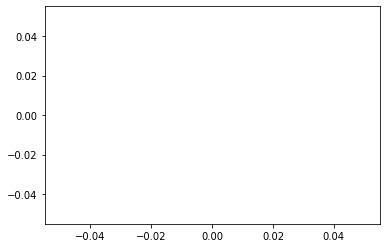

In [36]:
encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=1e-4)
decoder_optimizer = torch.optim.Adam(decoder.parameters(),lr=1e-4)

ELBO_history = []
for epoch in range(num_training_epochs):
    # make batches of training indices
    shuffled_idx = torch.randperm(train_x.shape[0])
    idx_batches = shuffled_idx.split(batch_size)

    sum_neg_ELBO = 0.0
    for batch_count, idx in enumerate(idx_batches):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        batch_x = train_x[idx, :]
        #batch_x = batch_x.float()
        # batch_mu_z: batch_size, num_latent
        # batch_var_z: batch_size, num_latent
        
        batch_x = batch_x.float()
        #print(len(batch_x))

        batch_mu_z, batch_var_z, batch_z = encoder(batch_x)
        
        # sample z, using the "reparametrization trick"
        #batch_z = batch_mu_z + torch.sqrt(batch_var_z) * torch.randn(batch_var_z.shape, device=device)

        # mu_x: batch_size, D
        mu_x = decoder(batch_z)

        # squared distances between mu_x and batch_x
        d2 = (mu_x - batch_x) ** 2
        # Gaussian likelihood: 1/sqrt(2*pi*var) exp(-0.5 * (mu-x)**2 / var)
        # Thus, log-likelihood = -0.5 * ( log(2*pi*var) + (mu-x)**2 / var )
        log_p = -0.5 * torch.sum(np.log(decoder.var * 2 * np.pi) + d2 / decoder.var)
        KL = -0.5 * torch.sum(1 + torch.log(batch_var_z) - batch_mu_z**2 - batch_var_z)

        # we want to maximize the ELBO, hence minimize the negative ELBO
        negative_ELBO = -log_p + KL
        negative_ELBO.backward()
        # update all model parameters
        encoder_optimizer.step()
        decoder_optimizer.step()

        sum_neg_ELBO += negative_ELBO

    mean_neg_ELBO = sum_neg_ELBO / train_x.shape[0]
    print('epoch {}   mean negative ELBO = {}'.format(epoch, mean_neg_ELBO))
    ELBO_history.append(mean_neg_ELBO)

    if epoch % 5 == 0:
        with torch.no_grad():
            # sample from the VAE
            x, z = decoder.sample(5)
            train_x = train_x.float()
            # encode some samples
            bat_z,mu_z, var_z = encoder(train_x[0:5, :])
            z_encoded = mu_z + torch.sqrt(var_z) * torch.randn(5, num_latent, device=device)

            # decode the samples
            x_decoded = decoder(z_encoded)

            # save images
            plot_img = np.stack((train_x[0:5, :].detach().cpu().numpy(),
                                 x_decoded.detach().cpu().numpy(),
                                 x.detach().cpu().numpy()))
            plot_img = np.reshape(plot_img, (15, 28, 28))
            file_name = os.path.join('img_vae', 'samples_{}.png'.format(epoch))
            #datasets.save_image_stack(plot_img, 3, 5, file_name, margin = 3)

        plt.figure(1)
        plt.clf()
        plt.plot(ELBO_history)
        plt.savefig(os.path.join('img_vae', 'elbo.png'))
